<a href="https://colab.research.google.com/github/lijerrymagic/MLColabAssignment/blob/master/Copy_of_10_hw_fine_tune_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning: classifying food items

* Name: Zeyu Li
* Net ID: zl3719

This week, we practiced using transfer learning to classify hand shapes as rock, paper, or scissors.

But this is a relatively easy problem. In this notebook, we'll work on classifying photographs of food items into 11 classes: bread, dairy product, dessert, egg, fried food, meat, noodles/pasta, rice, seafood, soup, and vegetable/fruit.

This is a more challenging problem, because there is a lot of intra-class variability and also some inter-class similarity.

To see what we mean by these, let's look at some examples of food photographs from the dataset that we'll work with.



Note: you can refer to this week's demo notebook for a closely related example.

Note: you may want to change the notebook's runtime type to GPU, for faster model training.

Note: this notebook is written using Tensorflow+Keras, but you are free to re-implement this task in PyTorch or other framework, if you prefer.



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image

import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get data

We are going to use the [Food-11 dataset](https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/), from the EPFL Multimedia Signal Processing Group. Here's a description:

> This is a dataset containing 16643 food images grouped in 11 major food categories. The 11 categories are Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit. Similar as Food-5K dataset, the whole dataset is divided in three parts: training, validation and evaluation. The same naming convention is used, where ID 0-10 refers to the 11 food categories respectively. 
>
> The total file size of the Food-11 dataset is about 1.16 GB.



In [ ]:
classes = np.array(["Bread", "Dairy product", "Dessert", "Egg", "Fried food",
	"Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup",
	"Vegetable/Fruit"])

In [ ]:
%cd /content
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/food-datasets/Food-11.zip --output-document Food-11.zip

/content
--2020-08-21 19:00:05--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/food-datasets/Food-11.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.237.248
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.237.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1163903300 (1.1G) [application/zip]
Saving to: ‘Food-11.zip’

Food-11.zip         100%[===================>]   1.08G  97.5MB/s    in 12s     

2020-08-21 19:00:17 (95.7 MB/s) - ‘Food-11.zip’ saved [1163903300/1163903300]



In [ ]:
!unzip Food-11.zip

Streaming output truncated to the last 5000 lines.
  inflating: Food-11/training/2_55.jpg  
  inflating: Food-11/training/2_550.jpg  
  inflating: Food-11/training/2_558.jpg  
  inflating: Food-11/training/2_560.jpg  
  inflating: Food-11/training/2_57.jpg  
  inflating: Food-11/training/2_588.jpg  
  inflating: Food-11/training/2_60.jpg  
  inflating: Food-11/training/2_606.jpg  
  inflating: Food-11/training/2_620.jpg  
  inflating: Food-11/training/2_623.jpg  
  inflating: Food-11/training/2_629.jpg  
  inflating: Food-11/training/2_632.jpg  
  inflating: Food-11/training/2_642.jpg  
  inflating: Food-11/training/2_649.jpg  
  inflating: Food-11/training/2_650.jpg  
  inflating: Food-11/training/2_660.jpg  
  inflating: Food-11/training/2_670.jpg  
  inflating: Food-11/training/2_679.jpg  
  inflating: Food-11/training/2_698.jpg  
  inflating: Food-11/training/2_704.jpg  
  inflating: Food-11/training/2_705.jpg  
  inflating: Food-11/training/2_734.jpg  
  inflating: Food-11/trainin

Click on the folder icon in Colab to view your filesystem and verify that you have the `Food-11` directory with `training`, `validation`, and `evaluation` subdirectories.

In [ ]:
training_dir = "Food-11/training/"
training_images = os.listdir(training_dir)
training_labels = np.array([int(f.split('_')[0]) for f in training_images ])

In [ ]:
validation_dir = "Food-11/validation/"
validation_images = os.listdir(validation_dir)
validation_labels = np.array([int(f.split('_')[0]) for f in validation_images ])

In [ ]:
evaluation_dir = "Food-11/evaluation/"
evaluation_images = os.listdir(evaluation_dir)
evaluation_labels = np.array([int(f.split('_')[0]) for f in evaluation_images ])

Let's look at a few random training samples:

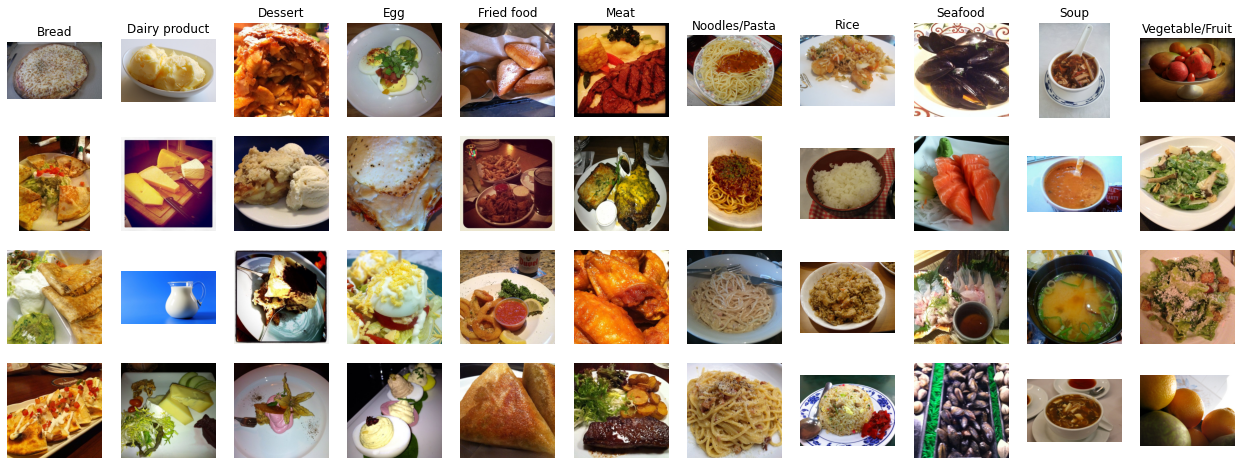

In [ ]:
num_classes = len(classes)
samples_per_class = 4
figure = plt.figure(figsize=(num_classes*2,samples_per_class*2))
for cls_idx, cls in enumerate(classes):
  idxs = np.flatnonzero(training_labels == cls_idx)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + cls_idx + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    im = Image.open(training_dir + training_images[idx])
    plt.imshow(im)
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()

We can see that two dessert samples (for example) may look very different from one another - intra-class variability. Furthermore, samples from two different classes, such as a rice dish and a noodles dish, may look very similar to one another - inter-class similarity.

(In fact, some foods may really belong to multiple classes.  For example, fried chicken should really have both the "fried food" and "meat" labels, but only one class label is provided for each sample in the dataset.)

## Prepare data directories

Because the Food-11 dataset is very large, we won't want to load the entire dataset into memory at once. 

Instead, Keras will let us read in images from disk as they are needed (in batches). For this to work, Keras [expects](https://keras.io/api/preprocessing/) that images will be organized in the following directory structure, with one subdirectory per class:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

So, we will have to re-organize our directory structure to match.

In [ ]:
%cd /content/Food-11/training/

# loop over classes
for i in range(len(classes)):
  # make a directory for this class inside Food-11/training
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  # get list of files inside Food-11/training that have this class label
  files = [f for f in os.listdir('/content/Food-11/training/') if f.startswith("%d_" % i)]
  # move each file to the subdirectory for the class
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/training


In [ ]:
%cd /content/Food-11/validation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/validation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/validation


In [ ]:
%cd /content/Food-11/evaluation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/evaluation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/evaluation


In [ ]:
# go back to default working directory
%cd /content

/content


Use the folder icon in Colab to look at your directory structure, and verify that within the training, validation, and evaluation data directories, there are subdirectories for each class containing the samples from that class.

## Prepare data generators

Now that we have prepared the directory structure, we can set up our data "flow".

In the next cell, I have defined a batch size and an image size. You are free to change these parameters, or you can keep them. You can use any batch size that has good results in training, and you can change the input image size to match the input shape of whatever base model you are using.

In [ ]:
# TODO 1 (optional) - design choice on batch size, image shape
BATCH_SIZE=32
INPUT_IMG_SIZE = 224

Then, I have defined some data generators to create augmented samples (slightly changed versions of the original samples). You are free to change the transformations used to generate the augmented data. You can learn more about the image transformations in the [ImageDataGenerator documentation](https://keras.io/api/preprocessing/image/#imagedatagenerator-class).

After we define the data generator, we use  `flow_from_directory` to get images off the disk during training, on an as-needed basis. 

In [ ]:
# TODO 2 (optional) - design choices on image transformations for data augmentation

# prepare ImageDataGenerator to create augmented training samples
training_aug = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1.0/255,          # rescales so each pixel is in 0-1 range - keep this
	rotation_range=1,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.1,
	horizontal_flip=True,
	fill_mode="nearest")

# prepare generator that pulls images from directory (and resizes)
training_gen = training_aug.flow_from_directory(
	'/content/' + training_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 9866 images belonging to 11 classes.


Check the mapping of directory names to class labels:

In [ ]:
training_gen.class_indices

{'class_00': 0,
 'class_01': 1,
 'class_02': 2,
 'class_03': 3,
 'class_04': 4,
 'class_05': 5,
 'class_06': 6,
 'class_07': 7,
 'class_08': 8,
 'class_09': 9,
 'class_10': 10}

We also set up the validation and evaluation (test) sets in a similar manner:

In [ ]:
validation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

validation_gen = validation_aug.flow_from_directory(
	'/content/' + validation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3430 images belonging to 11 classes.


Don't shuffle the evaluation set:

In [ ]:
evaluation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

evaluation_gen = evaluation_aug.flow_from_directory(
	'/content/' + evaluation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3347 images belonging to 11 classes.


## Prepare base model

Now that the data is ready, we need to prepare the model.


First, review the models available as [Keras Applications](https://keras.io/api/applications/), and decide which model you will use. Make sure to click through from the table to the model documentation, to learn more about each model you are considering.

In the cell that follows, I have used the [VGG16](https://keras.io/api/applications/vgg/) model, but you can change that - you may use any model that you think will have good results.

In [ ]:
# TODO 3 (optional) - design choice on base model

base_model = tf.keras.applications.VGG16(
  input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3),
  include_top=False,
  pooling='avg'
)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Train model with new classification head

In the following cell, "freeze" your base model (set it so that it is not trainable), and then construct a new model using the frozen base model with a new classification head.  (You can add a dropout layer in between if you think it will be helpful.)

(You can refer to this week's demo notebook for an example.)

In [ ]:
# TODO 4 (required) - prepare model with new classification head

model = tf.keras.models.Sequential()

# add to your model here...
base_model.trainable = False

model.add(base_model)

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=11,
    activation=tf.keras.activations.softmax
))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5643      
Total params: 14,720,331
Trainable params: 5,643
Non-trainable params: 14,714,688
_________________________________________________________________


Then, print a model summary:

In [ ]:
model.summary()

(Make sure that most parameters are "non-trainable", because you have frozen the base model!)

Compile your model with an appropriate optimizer and loss function, and use accuracy as a metric. 

In [ ]:
# TODO 5 (required) - design training parameters, and compile

# model.compile(...)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)


Finally, fit your model with the new classification head for as many epochs as you think is appropriate. You may also use early stopping if you think it will be helpful.

Pass the validation data generator as `validation_data`.

(You can refer to this week's demo notebook for an example.)

In [ ]:
# TODO 6 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

# n_epochs = ...
# hist = model.fit(...)
n_epochs = 20

hist = model.fit(
    training_gen, 
    epochs=n_epochs,
    steps_per_epoch=training_gen.n//BATCH_SIZE,
    validation_data=validation_gen, 
    validation_steps=validation_gen.n//BATCH_SIZE
)


Epoch 1/20
308/308 [==============================] - 187s 606ms/step - loss: 2.0688 - accuracy: 0.2827 - val_loss: 1.7454 - val_accuracy: 0.4486
Epoch 2/20
308/308 [==============================] - 188s 609ms/step - loss: 1.7277 - accuracy: 0.4270 - val_loss: 1.5490 - val_accuracy: 0.5166
Epoch 3/20
308/308 [==============================] - 187s 609ms/step - loss: 1.6063 - accuracy: 0.4628 - val_loss: 1.4453 - val_accuracy: 0.5470
Epoch 4/20
308/308 [==============================] - 188s 610ms/step - loss: 1.5280 - accuracy: 0.4918 - val_loss: 1.3788 - val_accuracy: 0.5596
Epoch 5/20
308/308 [==============================] - 187s 608ms/step - loss: 1.4746 - accuracy: 0.5089 - val_loss: 1.3344 - val_accuracy: 0.5637
Epoch 6/20
308/308 [==============================] - 188s 609ms/step - loss: 1.4334 - accuracy: 0.5197 - val_loss: 1.2903 - val_accuracy: 0.5935
Epoch 7/20
308/308 [==============================] - 188s 611ms/step - loss: 1.4130 - accuracy: 0.5218 - val_loss: 1.2663 -

Plot the training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot.

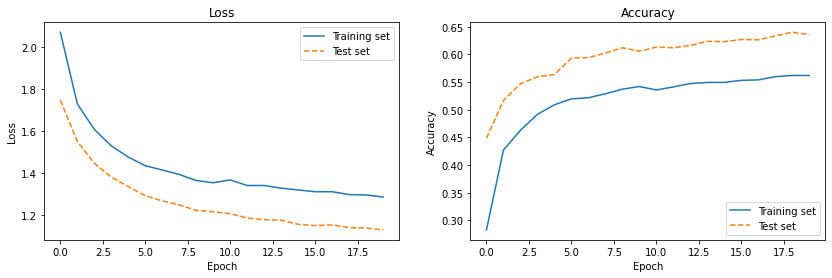

In [ ]:
# TODO 7 (required) - plot training history
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()

plt.show()


## Fine-tune model

Next, we are going to "un-freeze" the later layers of the model, and train it for a few more epochs on our data (with a smaller learning rate), so that it is better suited for our specific classification task.

Note that you should *not* create a new model. We're just going to continue training the model we already started training.

First, we will un-freeze the base model:

In [ ]:
base_model.trainable = True

Then, we will re-freeze only the first layers of the base model. In the cell below, I have left the last five layers, which includes the last set of convolutional filters, unfrozen. But you are free to change this number if you think you will get better performance.

In [ ]:
# TODO 8 (optional) - you can decide how many layers to unfreeze

for layer in base_model.layers[:-5]:
	layer.trainable = False

The output of the following cell will indicate which layers in the base model are trainable, and which are not:

In [ ]:
for layer in base_model.layers:
  print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fbaee502f98>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbaee991da0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbaebad36a0>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fbaebad3ac8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbaeba2a7b8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbaeba3e630>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fbaeba3e6d8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbaeba43278>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbaeba43e80>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbaeba4a518>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fbaeba4ad68>: False
<tensorflow.python.keras.layers.convolutional.Conv2D

Also, the model summary should now show more trainable parameters:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5643      
Total params: 14,720,331
Trainable params: 5,643
Non-trainable params: 14,714,688
_________________________________________________________________


Re-compile your model, with a smaller learning rate.

In [ ]:
# TODO 9 (required) - re-compile model
# use a smaller learning rate for fine-tuning

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    optimizer = opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)



Fit your model (with some newly unfrozen layers) for some more epochs.

In [ ]:
# TODO 10 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

# n_epochs_fine = ...
# hist_fine = model.fit(...)
n_epochs_fine = 10

hist_fine = model.fit( 
    training_gen, 
    epochs=n_epochs + n_epochs_fine,
    initial_epoch=n_epochs,  
    steps_per_epoch=training_gen.n//BATCH_SIZE,
    validation_data=validation_gen, 
    validation_steps=validation_gen.n//BATCH_SIZE
)

Epoch 21/30
308/308 [==============================] - 191s 620ms/step - loss: 1.2819 - accuracy: 0.5648 - val_loss: 1.1252 - val_accuracy: 0.6384
Epoch 22/30
308/308 [==============================] - 191s 619ms/step - loss: 1.2790 - accuracy: 0.5611 - val_loss: 1.1252 - val_accuracy: 0.6384
Epoch 23/30
308/308 [==============================] - 193s 626ms/step - loss: 1.2882 - accuracy: 0.5601 - val_loss: 1.1250 - val_accuracy: 0.6393
Epoch 24/30
308/308 [==============================] - 192s 623ms/step - loss: 1.2706 - accuracy: 0.5699 - val_loss: 1.1242 - val_accuracy: 0.6399
Epoch 25/30
308/308 [==============================] - 191s 620ms/step - loss: 1.2897 - accuracy: 0.5599 - val_loss: 1.1234 - val_accuracy: 0.6393
Epoch 26/30
308/308 [==============================] - 191s 619ms/step - loss: 1.2727 - accuracy: 0.5694 - val_loss: 1.1245 - val_accuracy: 0.6381
Epoch 27/30
308/308 [==============================] - 193s 626ms/step - loss: 1.2749 - accuracy: 0.5721 - val_loss: 1

Plot the complete training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot. Draw a vertical line demarcating the first stage of training (training the classification head) and the second stage of training (fine tuning).

(You can refer to this week's demo notebook for an example.)

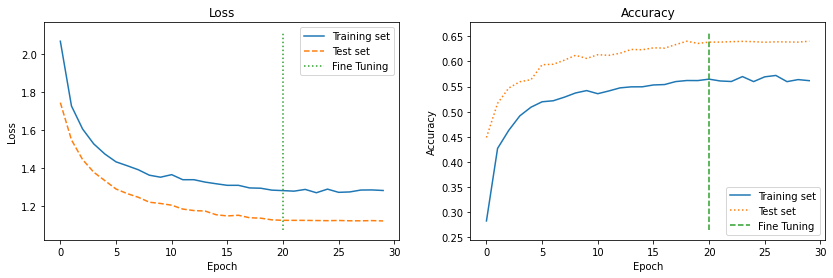

In [ ]:
# TODO 11 (required) - plot training history
loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

accuracy = hist.history['accuracy'] + hist_fine.history['accuracy']
val_accuracy = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot([n_epochs, n_epochs], plt.ylim(),label='Fine Tuning',linestyle='dotted')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='dotted')
plt.plot([n_epochs, n_epochs], plt.ylim(), label='Fine Tuning', linestyle='--')
plt.legend()

plt.show()

## Evaluate model performance


Once you have finished training your model, use `evaluate` to get the model performance - loss and accuracy - on the evaluation set. (You should not use the evaluation set at all prior to this step.)

In [ ]:
model.evaluate(evaluation_gen)

105/105 [==============================] - 26s 249ms/step - loss: 1.0622 - accuracy: 0.6558


[1.0621600151062012, 0.6558111906051636]

We can also create a confusion matrix, to see which which classes are most often confused with one another.

In [ ]:
y_pred_prob = model.predict(evaluation_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

In [ ]:
cm = pd.crosstab(evaluation_gen.classes, y_pred, 
                               rownames=['Actual'], colnames=['Predicted'],
                               normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False);
p = plt.xticks(ticks=np.arange(0,11+1), labels=classes, rotation=45)
p = plt.yticks(ticks=np.arange(0,11+1), labels=classes, rotation=45)

## Use model on your own custom image

Take your own photograph of a food item in one of the 11 classes. Upload it to Colab, load it as a numpy array, and process the image (resize it, and scale so that each pixel takes on a value from 0 to 1).

Then, use the fitted model to get the per-class probabilities for each class. 


Plot your image, and a bar plot showing the probability for the 5 most likely classes according to the model.

(You can refer to the "Classify with MobileNetV2" section of this week's notebook for an example.)

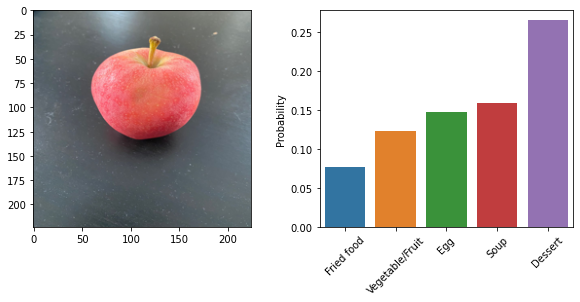

In [ ]:
# TODO 12 (required) - show example of model use in "production"
from PIL import Image
 
# Edit the filename here as needed
filename = 'apple.jpg'
 
# pre-process image
image = Image.open(filename).convert('RGB')
image_resized = image.resize((INPUT_IMG_SIZE, INPUT_IMG_SIZE), Image.BICUBIC)
test_sample = np.array(image_resized)/255.0
test_sample = test_sample.reshape(1, INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)

import seaborn as sns

classes = np.array(["Bread", "Dairy product", "Dessert", "Egg", "Fried food",
    "Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup",
    "Vegetable/Fruit"])

probs = model.predict(test_sample)
probs.shape

most_likely_classes = np.argsort(probs.squeeze())[-5:]

plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

plt.subplot(1,2,2)
p = sns.barplot(classes[most_likely_classes],probs.squeeze()[most_likely_classes]);
plt.ylabel("Probability");
p.set_xticklabels(p.get_xticklabels(), rotation=45);

## Describe your model - TODO 13 (required)

In the following cell, describe your final model and your results, by answering the following questions.

* What base model did you use? How many parameters does this base model have?

      VGG16 model. it has 138,357,544 parameter in the base model.

* Describe the specific transformations you used to create an augmented data set.
      I rescaled, rotated, shifted and flipped the image to create augmented data set.

* For how many epochs did you train your classification head, and with what optimizer, learning rate, and batch size? What was the validation accuracy at the end of this training stage?
      I used 20 epochs with Adam optimizer and 0.001 learnig rate and 32 batch size.The validation accuracy in the end was 0.6358

* Which layers did you un-freeze for fine-tuning, how many epochs did you fine-tune for, and what optimizer, learning rate, and batch size did you use for fine-tuning? What was the validation accuracy at the end of this training stage?
      Later layers. I fined tuned for 10 epochs with Adma optimizer, 0.00001 learning rate. Validation accuracy was 0.6402.
* What was your final accuracy on the evaluation set?
      My final accuracy was 0.6558.
* Did your model correctly predict the class of your custom test image?
      Kind of, the class whichi t belongs to shows in the top 5 probability classes, but not show as the highest one. But was close.